# Lab2

## Import

In [13]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def r(d):
    img = cv2.imread(d)
    h, w = img.shape[:2]
    target_width = 300
    scale = target_width / w
    new_height = int(h * scale)
    return cv2.resize(img, (target_width, new_height), interpolation=cv2.INTER_AREA)


img1 = r('./image1.jpg')
img2 = r('./image2.jpg')

gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

## Task 1

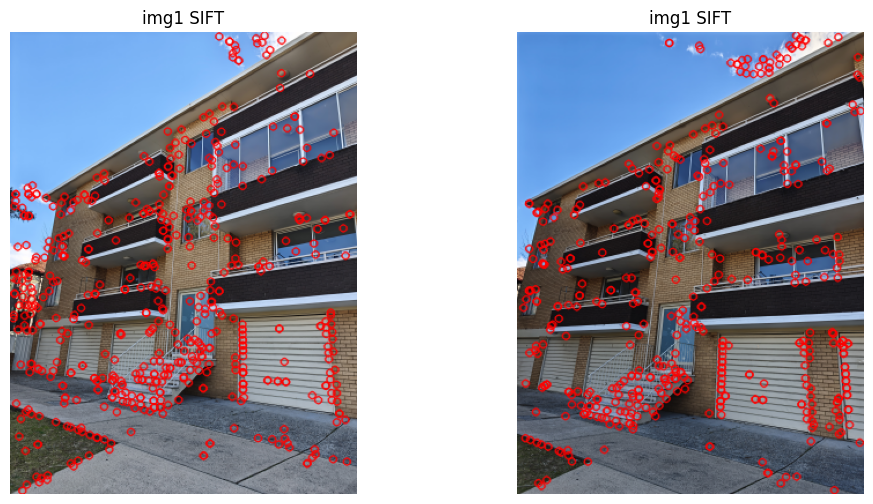

In [14]:
detector = cv2.SIFT_create()

kp1, des1 = detector.detectAndCompute(img1, None)
kp2, des2 = detector.detectAndCompute(img2, None)

img1_kp = cv2.drawKeypoints(img1, kp1, None, color=(0, 0, 255))
img2_kp = cv2.drawKeypoints(img2, kp2, None, color=(0, 0, 255))

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('img1 SIFT')
plt.imshow(cv2.cvtColor(img1_kp, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('img1 SIFT')
plt.imshow(cv2.cvtColor(img2_kp, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

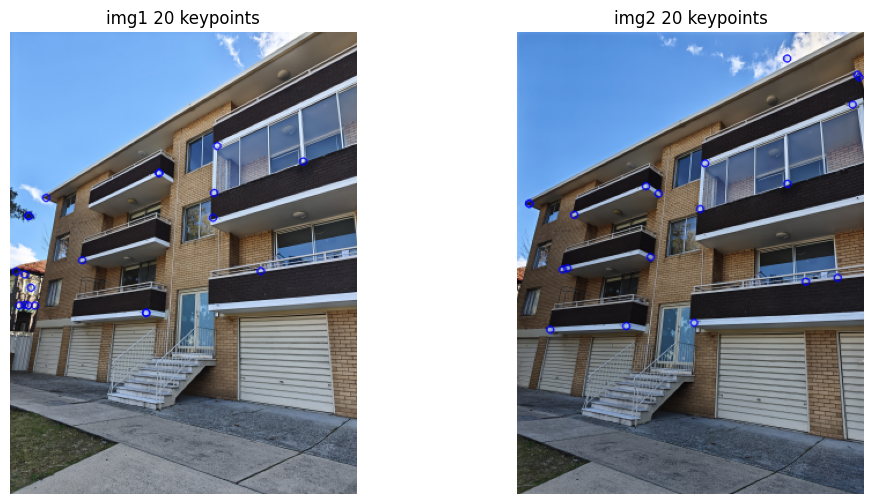

In [15]:
detector_20 = cv2.SIFT_create(nfeatures=20)

kp1_20, des1_20 = detector_20.detectAndCompute(img1, None)
kp2_20, des2_20 = detector_20.detectAndCompute(img2, None)

img1_kp20 = cv2.drawKeypoints(img1, kp1_20, None, color=(255, 0, 0))
img2_kp20 = cv2.drawKeypoints(img2, kp2_20, None, color=(255, 0, 0))

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('img1 20 keypoints')
plt.imshow(cv2.cvtColor(img1_kp20, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('img2 20 keypoints')
plt.imshow(cv2.cvtColor(img2_kp20, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

By setting nfeatures=20 to retain only the top 20 key points with the highest response values, it is more conducive to visualization.

## Task 2

In [16]:
def p(m1, m2, title):
    d = cv2.SIFT_create(nfeatures=20)
    k1, _ = d.detectAndCompute(img1, None)
    k2, _ = d.detectAndCompute(img2, None)
    cv2.drawKeypoints(m1, k1, m1, color=(255, 0, 0))
    cv2.drawKeypoints(m2, k2, m2, color=(255, 0, 0))
    plt.figure(figsize=(12, 5))

    plt.suptitle(title)
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(m1, cv2.COLOR_BGR2RGB))
    plt.title('Image1')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(m2, cv2.COLOR_BGR2RGB))
    plt.title('Image2')
    plt.axis('off')
    plt.show()

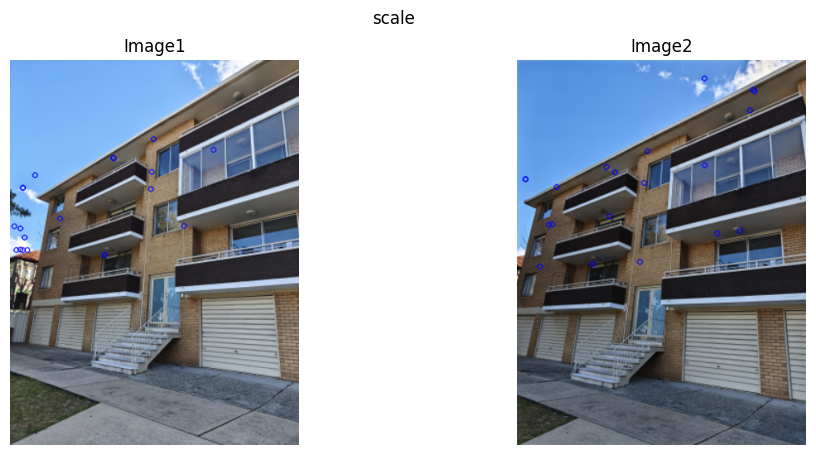

In [17]:
p(cv2.resize(img1, None, fx=1.2, fy=1.2, interpolation=cv2.INTER_LINEAR)
    ,cv2.resize(img2, None, fx=1.2, fy=1.2, interpolation=cv2.INTER_LINEAR)
    ,'scale')

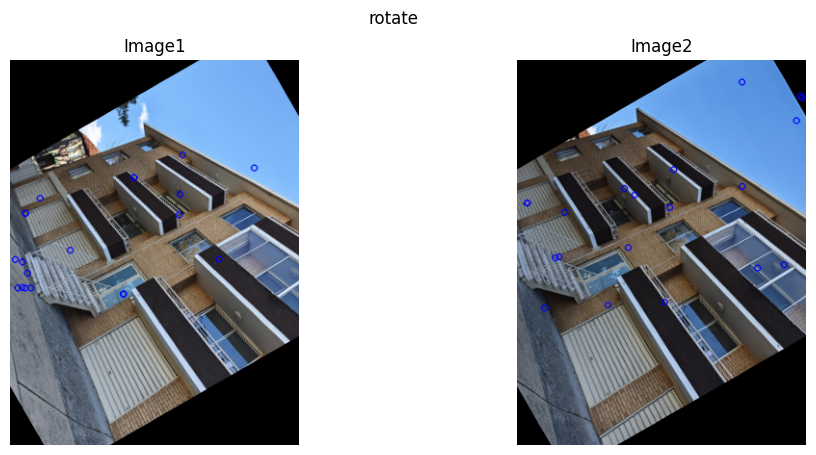

In [18]:
h, w = img1.shape[:2]
M = cv2.getRotationMatrix2D((w/2, h/2), -60, 1)
rotated1 = cv2.warpAffine(img1, M, (w, h))

h, w = img2.shape[:2]
M = cv2.getRotationMatrix2D((w/2, h/2), -60, 1)
rotated2 = cv2.warpAffine(img2, M, (w, h))

p(rotated1, rotated2,'rotate')

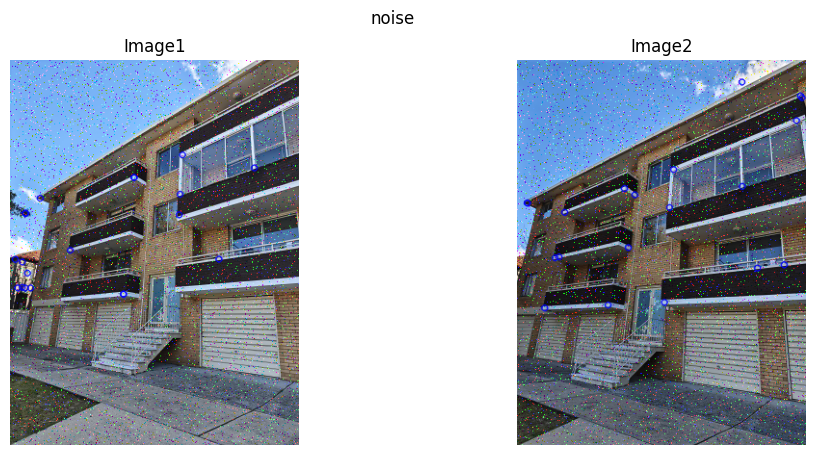

In [19]:
from skimage.util import random_noise

noisy1 = (random_noise(img1, mode='s&p', amount=0.03) * 255).astype(np.uint8)
noisy2 = (random_noise(img2, mode='s&p', amount=0.03) * 255).astype(np.uint8)

p(noisy1, noisy2, 'noise')


- Scale 120%: Keypoints remain largely unchanged, confirming SIFT's scale invariance.
- Rotation60: Most salient points are preserved but their orientation arrows rotate correspondingly, demonstrating rotation invariance.
- Salt‑and‑pepper noise: Some distinctive corners survive, yet several weak points disappear. SIFT is less robust to impulse noise compared with scale or rotation.

Overall, SIFT shows the highest robustness to uniform scaling and rotation, and lower robustness to noise contamination.

## Task 3

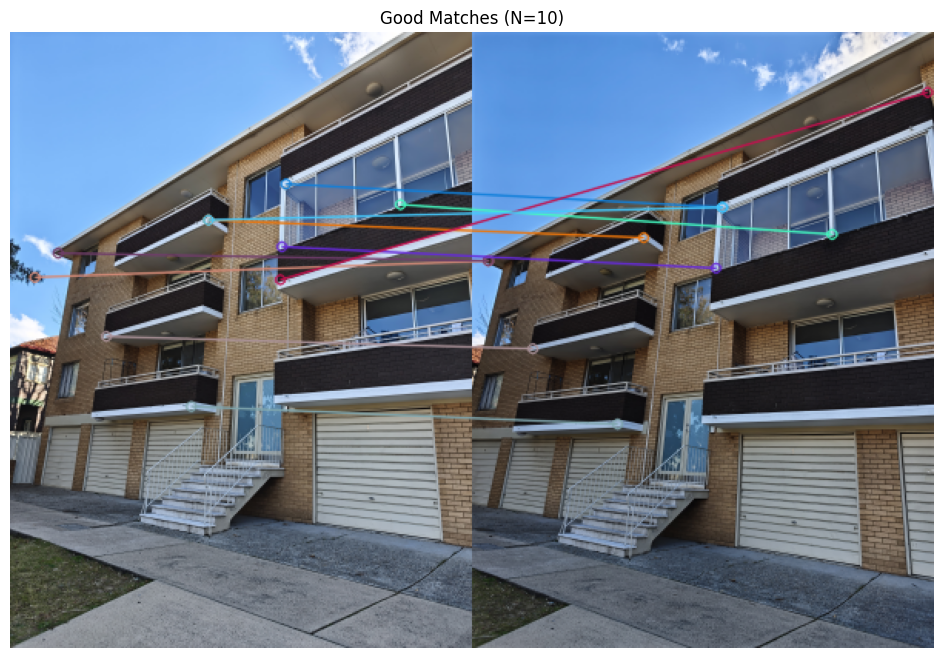

In [20]:
bf = cv2.BFMatcher(cv2.NORM_L2)
matches = bf.knnMatch(des1_20, des2_20, k=2)
# matches = bf.knnMatch(des1, des2, k=2)

# Lowe ratio test
good = [m for m, n in matches if m.distance < 0.75 * n.distance]

img_matches = cv2.drawMatches(img1, kp1_20, img2, kp2_20, good, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
# img_matches = cv2.drawMatches(img1, kp1, img2, kp2, good, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.figure(figsize=(16, 8))
plt.imshow(cv2.cvtColor(img_matches, cv2.COLOR_BGR2RGB))
plt.title(f'Good Matches (N={len(good)})')
plt.axis('off')
plt.show()

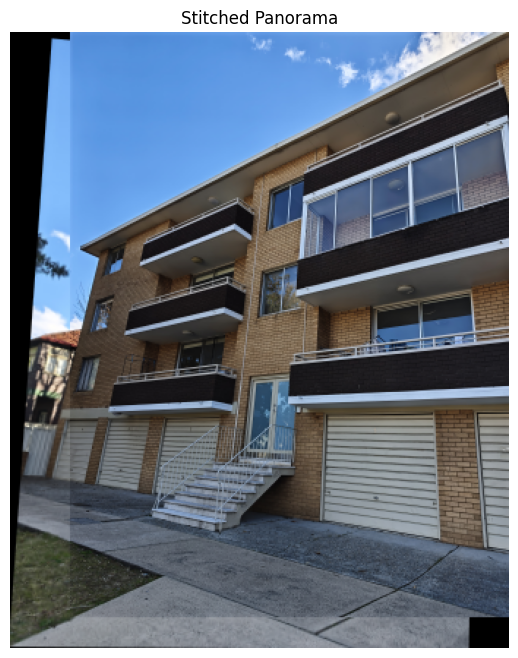

In [21]:
src_pts = np.float32([kp1_20[m.queryIdx].pt for m in good]).reshape(-1, 1, 2)
dst_pts = np.float32([kp2_20[m.trainIdx].pt for m in good]).reshape(-1, 1, 2)

H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

h2, w2 = img2.shape[:2]
h1, w1 = img1.shape[:2]
corners_img1 = np.float32([[0, 0], [0, h1], [w1, h1], [w1, 0]]).reshape(-1, 1, 2)
warped_corners = cv2.perspectiveTransform(corners_img1, H)
all_corners = np.concatenate((warped_corners, np.float32([[0, 0], [0, h2], [w2, h2], [w2, 0]]).reshape(-1, 1, 2)), axis=0)
[xmin, ymin] = np.int32(all_corners.min(axis=0).ravel())
[xmax, ymax] = np.int32(all_corners.max(axis=0).ravel())
translation = [-xmin, -ymin]
H_trans = np.array([[1, 0, translation[0]], [0, 1, translation[1]], [0, 0, 1]]) @ H
stitched = cv2.warpPerspective(img1, H_trans, (xmax - xmin, ymax - ymin))
stitched[translation[1]:translation[1] + h2, translation[0]:translation[0] + w2] = img2

plt.figure(figsize=(12, 8))
plt.imshow(cv2.cvtColor(stitched, cv2.COLOR_BGR2RGB))
plt.title('Stitched Panorama')
plt.axis('off')
plt.show()